In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

# 1. Synthetic dataset - proof of concept

Classifer process. Data dimensionality detected is 2. regularity = 6


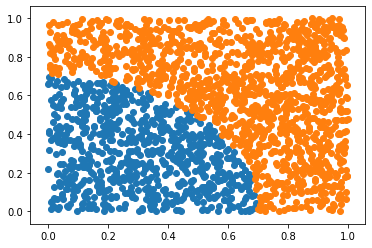

In [2]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

In [3]:
test = dg.gen(N=200, border=0.7)

path, knn = 0, 0
for t in test:
    path += classifier.classify_by_path(t[0], attempts=9) == t[1]
    knn += classifier.classify_knn(t[0], attempts=9) == t[1]
    
print(f"Path classifier accuracy = {100 * path / len(test):.2f}%")
print(f"Knn classifier accuracy = {100 * knn / len(test):.2f}%")

Path classifier accuracy = 98.50%
Knn classifier accuracy = 98.00%


# 2. Simple case: MINST

In [4]:
!python -m pip install mnist

In [5]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train, test = XY[:4 * len(XY) // 5], XY[4 * len(XY) // 5:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train, attempts=20)

Classifer process. Data dimensionality detected is 64. regularity = 192


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
MNIST: Path classifier accuracy = 98.89%
MNIST: Knn classifier accuracy = 97.78%


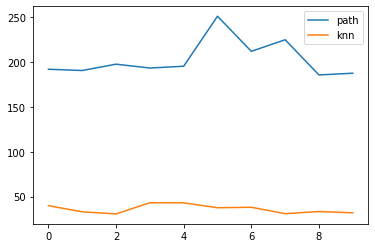

In [7]:
import time

path_times, knn_times = [], []
path, knn = 0, 0
times = 10

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += minst_classifier.classify_by_path(t[0], attempts=9) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += minst_classifier.classify_knn(t[0], attempts=9) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"MNIST: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"MNIST: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

# 3. Harder case: CIFAR-10

In [10]:
import shutil
import requests
import tarfile

filename = "cifar-10-python.tar.gz"
cifar_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

if not os.path.exists(filename):
    response = requests.get(cifar_url, stream=True)
    with open('cifar-10-python.tar.gz', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()

(50000, 3072) (50000, 1)


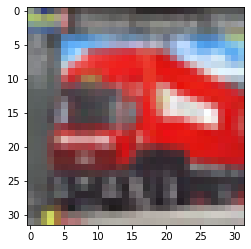

In [30]:
import pickle
folder = "cifar-10-batches-py"

datas = []
labels = []

for i in range(1, 6):
    with open(f"{folder}/data_batch_{i}", 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        X, Y = batch[b'data'], [[x] for x in batch[b'labels']]
        datas.append(X)
        labels.append(Y)
        
with open(f"{folder}/test_batch", 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
    Xtest, Ytest = batch[b'data'], [[x] for x in batch[b'labels']]
    test = list(zip(Xtest, Ytest))
       
X = np.vstack(datas)
Y = np.vstack(labels)
print(X.shape, Y.shape)
XY = np.hstack((X, Y))
np.random.shuffle(XY)
X, Y = XY[:, :3072], XY[:, -1]
XY = list(zip(X, Y))

im = X[1].reshape(3, 32, 32)
im = np.moveaxis(im, 0, -1)
plt.imshow(im)
plt.show()

In [ ]:
cifar_classifier = NSWClassifier()
cifar_classifier.build_navigable_graph(XY, attempts=20)

path_times, knn_times = [], []
path, knn = 0, 0
times = 3

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += cifar_classifier.classify_by_path(t[0], attempts=9) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += cifar_classifier.classify_knn(t[0], attempts=9) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"CIFAR-10: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"CIFAR-10: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

Classifer process. Data dimensionality detected is 3072. regularity = 9216
